In [13]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx

In [2]:
fn_metadata = "/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/preprocessing/gm_metadata_expanded.csv"
df_metadata = pd.read_csv(fn_metadata)

In [5]:
eq_samples = df_metadata.drop_duplicates(subset='eq_id', keep='first').reset_index(drop=True)

Creating GeoJSON: 100%|██████████| 9283/9283 [02:49<00:00, 54.81it/s] 


GeoJSON file created: ./eq_samples.geojson


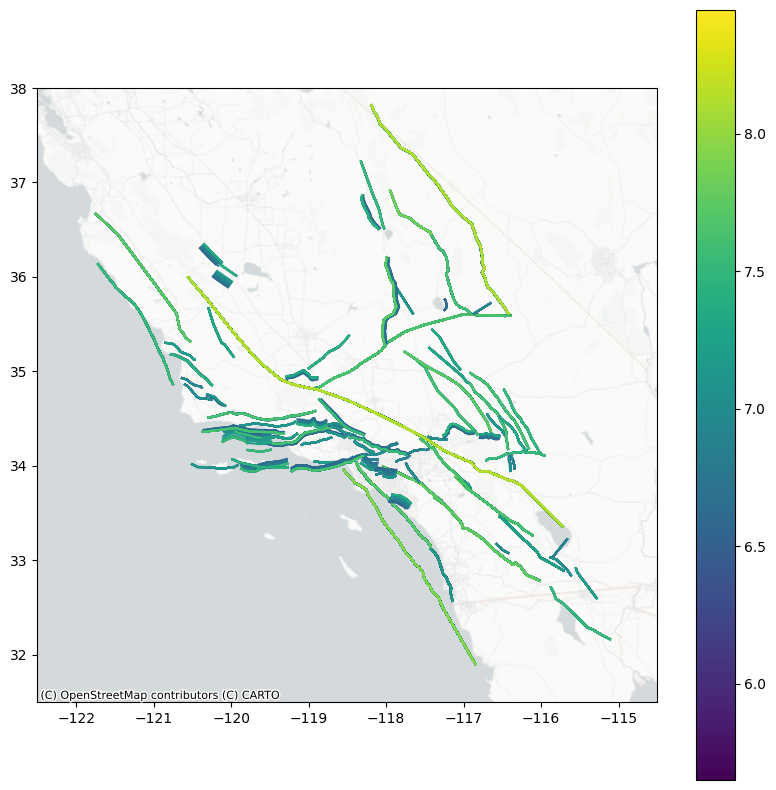

In [ ]:
"""Create a GeoJSON file with the locations of the earthquakes."""
src_dir = "/resnick/groups/enceladus/glavrent/Scalable_GPs/Raw_files/scec/ruptures_erf36"

out_file = "./eq_samples.geojson"
for index, row in tqdm(eq_samples.iterrows(), total=len(eq_samples), 
                       desc=f"Creating GeoJSON"):
    source_id = int(row['source_id'])
    rupture_id = int(row['rupture_id'])
    source_file = os.path.join(src_dir, f"{source_id}_{rupture_id}.txt")
    with open(source_file, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]

        # Extract the first line which is the probability
        prob = float(lines[0].split('=')[1].strip())
        # Extract the second line which is the magnitude
        magnitude = float(lines[1].split('=')[1].strip())
        # Extract the fourth line which is the number of rows
        num_rows = int(lines[3].split('=')[1].strip())
        # Extract the fifth line which is the number of columns
        num_cols = int(lines[4].split('=')[1].strip())
        # Approximate the rupture geometry of with the first row
        data = []
        for line in lines[6:6 + num_cols]:
            if line.strip():
                data.append([float(x) for x in line.split()])
        data = np.array(data)
        lon_lat = data[:, [1, 0]]
        geometry = shapely.geometry.LineString(lon_lat.tolist())
    eq_samples.loc[index, 'geometry'] = geometry
    eq_samples.loc[index, 'probability'] = prob
    eq_samples.loc[index, 'magnitude'] = magnitude

gdf = gpd.GeoDataFrame(eq_samples, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)  # Set the coordinate reference system
# gdf.to_file(out_file, driver='GeoJSON')
makeplot = True
if makeplot:
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, column='magnitude', legend=True, cmap='viridis', markersize=5)
    ax.set_ylim([31.5, 38.0])
    ax.set_xlim([-122.5, -114.5])
    ctx.add_basemap(ax, crs=gdf.crs.to_string(),  source=ctx.providers.CartoDB.PositronNoLabels)
    # fig.savefig(out_file.replace('.geojson', '.png'))
    # plt.close(fig)
print(f"GeoJSON file created: {out_file}")

TypeError: only length-1 arrays can be converted to Python scalars

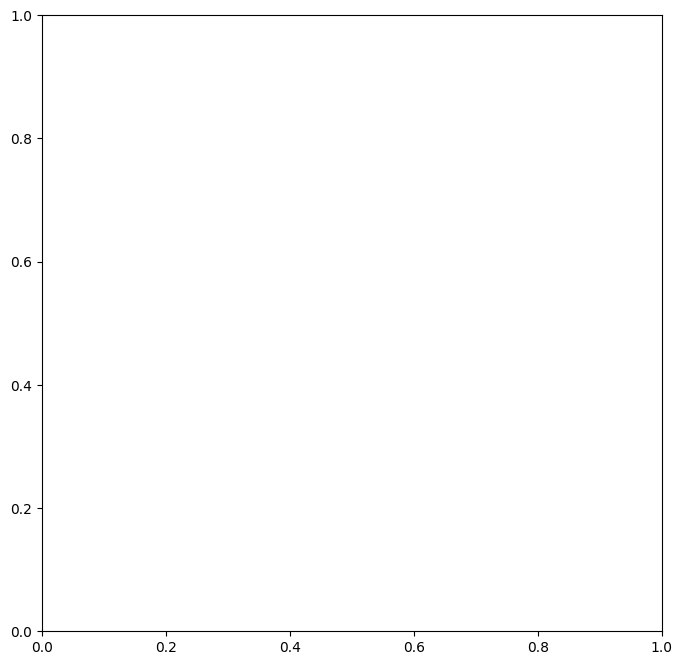

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Create a colormap from yellow to hot_r
hot_r = plt.cm.hot_r  # Get the hot_r colormap
colors = [hot_r(i) for i in range(int(256*0.3), int(256*0.9))]# Start with yellow, then use hot_r
cmap = LinearSegmentedColormap.from_list("yellow_to_hot_r", colors)
cmap = hot_r
vmin = eq_samples['magnitude'].min()
vmax = eq_samples['magnitude'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
mapper = ScalarMappable(norm=norm, cmap=cmap)

# Use color to represent Magnitude
color = mapper.to_rgba(eq_samples['magnitude']) 
# Use thickness to represent MeanAnnualRate
th_max = 6
th_min = 1
thick_data = (eq_samples['probability'].values)
thickness = th_min + (thick_data - thick_data.min()) / (thick_data.max() - thick_data.min()) * (th_max - th_min)
# Plot the line ruptures with color and thickness
eq_samples.plot(ax=ax, linewidth=thickness, color=color, alpha=0.7)

# Change axis labels
ax.set_xticks(np.arange(-120, -114, 1))
ax.set_yticks(np.arange(32, 37.1, 1))
ax.set_xticklabels([f'{-x:.0f}°W' for x in ax.get_xticks().tolist()], font_properties={
        "size": 12,
    })
ax.set_yticklabels([f'{x:.0f}°N' for x in ax.get_yticks().tolist()], font_properties={
        "size": 12,
    })
# Add colorbar
cbar = fig.colorbar(mapper, ax=ax, orientation='vertical', fraction=0.04, pad=0.04)
cbar.set_label('Magnitude', fontsize = 12, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=12)

# Mean Annual Rate legend
MAR_to_plot = np.linspace(1e-6, 2.5e-3, 5)
for mar in MAR_to_plot:
    ax.plot([], [], color='black', linewidth=th_min + (mar -thick_data.min()) / (thick_data.max() - thick_data.min()) * (th_max - th_min), label=f'{mar:.2e}')
ax.legend(title='Annual Occurrence Rate', fontsize=12, title_fontsize=12, loc='lower left')

GeoJSON file created: ./eq_samples.geojson


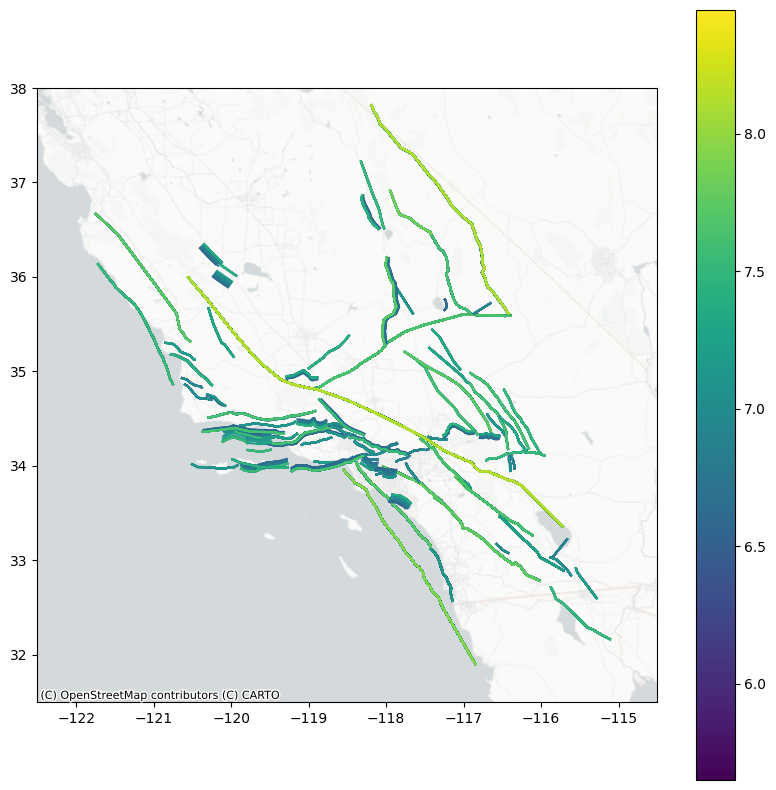

In [ ]:
makeplot = True
if makeplot:
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, column='magnitude', legend=True, cmap='viridis', markersize=5)
    ax.set_ylim([31.5, 38.0])
    ax.set_xlim([-122.5, -114.5])
    ctx.add_basemap(ax, crs=gdf.crs.to_string(),  source=ctx.providers.CartoDB.PositronNoLabels)
    # fig.savefig(out_file.replace('.geojson', '.png'))
    # plt.close(fig)
